# Wiener filter for speech enhancement

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/skoyamalab/teaching/blob/master/wiener_filter.ipynb)

In [ ]:
# Download CMU_ARCTIC speech dataset
# URL: http://www.festvox.org/cmu_arctic/
!wget -P Downloads http://festvox.org/cmu_arctic/cmu_arctic/cmu_us_bdl_arctic/wav/arctic_a0001.wav

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import wavfile
import IPython.display

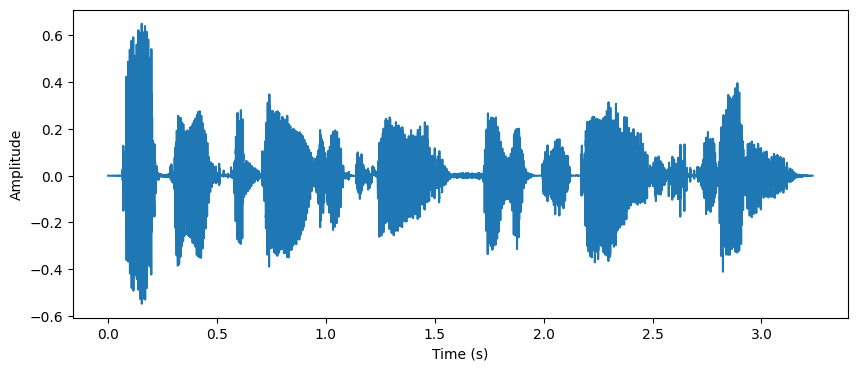

In [ ]:
fs, sig = wavfile.read('Downloads/arctic_a0001.wav') # Load speech signal
sig = sig / (2**(16-1))  # Normalize 16-bit PCM
nsamples = sig.shape[0]
time = np.arange(nsamples) / fs  

# Plot speech signal
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(time, sig)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')
plt.show()

IPython.display.Audio(sig, rate=fs)

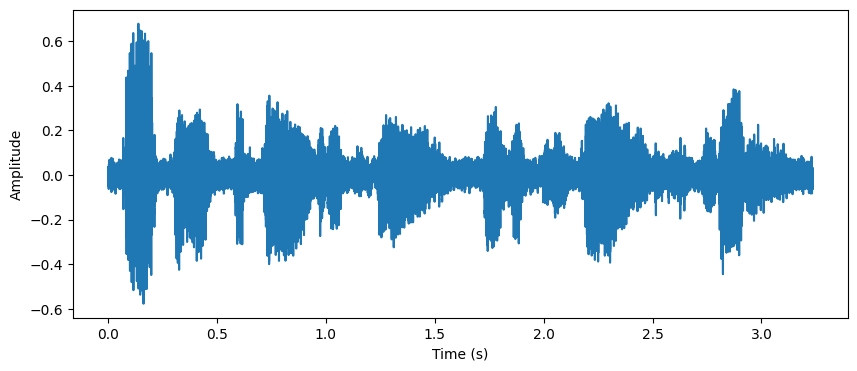

In [2]:
snr = 10
Ps = sum(sig**2) / nsamples  # Signal power
Pn = Ps / (10**(snr / 10))    # Noise power

# Generate white Gaussian noise
noise = np.random.normal(0, np.sqrt(Pn), nsamples)

# Noisy speech signal
sig_noisy = sig + noise

# Plot noisy speech signal
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(time, sig_noisy)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')
plt.show()

IPython.display.Audio(sig_noisy, rate=fs)

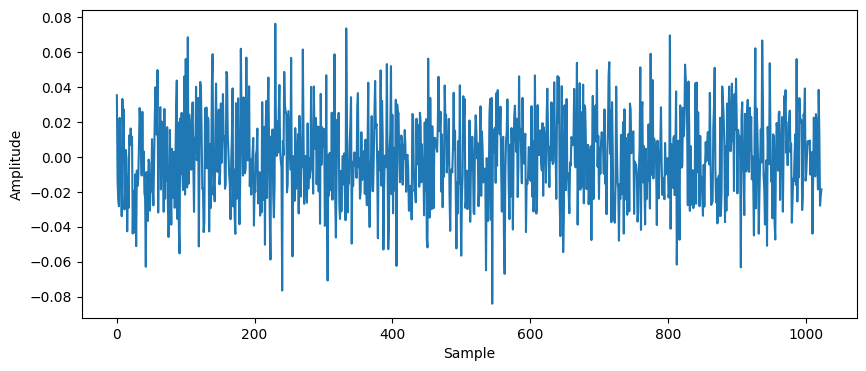

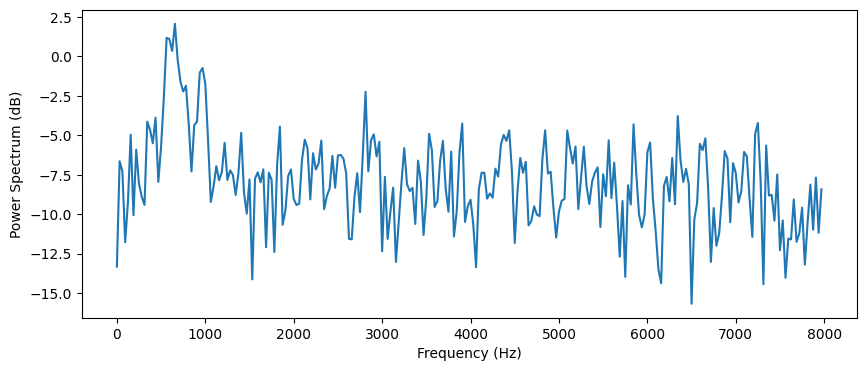

In [ ]:
# FFT parameters
fftlen = 512
fftshift = fftlen // 2

# Frequency
freq = np.fft.fftfreq(fftlen) * fs

# Window function
win = np.sqrt(np.hanning(fftlen))

# Estimate noise power from noisy signal from first few frames
nframes_noise = 4

# Plot first few frames of noisy signal
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(sig_noisy[0:(nframes_noise * fftshift)])
ax.set_xlabel('Sample')
ax.set_ylabel('Amplitude')
plt.show()

Sn = np.zeros(fftlen) # Noise power spectrum density
for n in range(nframes_noise):
    start = n * fftshift
    x = sig_noisy[start:(start+fftlen)] * win
    xf = np.fft.fft(x, n=fftlen)
    Sn += (1 / nframes_noise) * (np.abs(xf) ** 2)

# Plot estimated noise power spectrum
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(freq[:fftlen // 2], 10 * np.log10(Sn[:fftlen // 2]))
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power Spectrum (dB)')
plt.show()

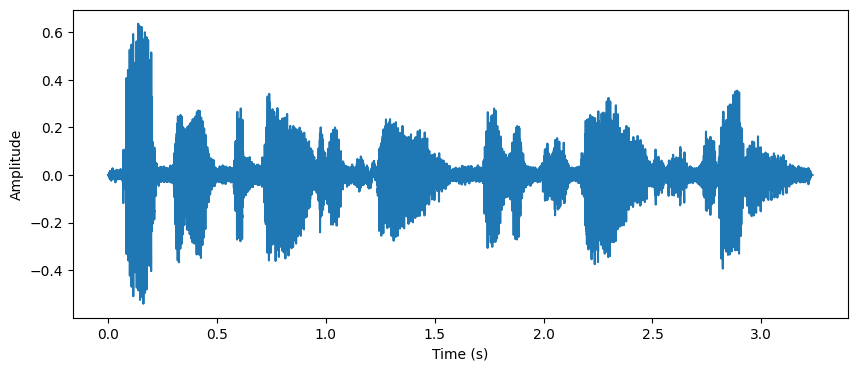

In [ ]:
# Wiener filtering for noise reduction
sig_denoised = np.zeros(nsamples)
nframes = (nsamples - fftlen) // fftshift + 1

for n in range(nframes):
    start = n * fftshift
    x = sig_noisy[start:(start+fftlen)] * win
    xf = np.fft.fft(x, n=fftlen)
    
    # Wiener filter
    Sx = np.abs(xf) ** 2 # Speech power spectrum density
    WF = np.maximum(0, (Sx - Sn) / Sx)
    
    # Apply filter
    xf_denoised = WF * xf
    x_denoised = np.fft.ifft(xf_denoised).real
    
    # Overlap-add
    sig_denoised[start:(start+fftlen)] += x_denoised * win

# Plot denoised speech signal
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(time, sig_denoised)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')
plt.show()

IPython.display.Audio(sig_denoised, rate=fs)